In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'

genome_scores = data_dir + 'tag_genome.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'

genomes_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')
genome_score_movies = genomes_df.index.values
ratings_df = pd.read_csv(ratings, usecols=range(3), dtype={'userId':np.int64, 'movieId':np.int64, 'rating':np.float64}, low_memory=False)
ratings_df = ratings_df[ratings_df['movieId'].isin(genome_score_movies)]
ratings_df

,userId,movieId,rating
72,142882,257,0.5
98,142882,428,2.5
99,142882,381,1.0
102,142882,765,0.5
104,142882,374,0.5
105,142882,481,1.5
111,142882,837,2.0
134,142882,60,1.5
145,142912,589,4.0
179,142882,105,2.5


In [46]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
    
def get_users_best_silhouette_score(user_id, genome_scores_df):
    user_movie_tags_df = pd.DataFrame()
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    user_movie_tags_df = genome_scores_df[genome_scores_df.index.isin(user_movies)]
    n_movies = user_movie_tags_df.index.size
    
    highest_score = 0
    optimal_cluster_size = 2

    user_movies_matrix = np.nan_to_num(user_movie_tags_df.values[:n_movies])
    
    for cluster_size in range(2, n_movies-1, 1):
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(user_movies_matrix)
        score = silhouette_score(user_movies_matrix, result, metric='cosine')
#         cluster_size_silhouette_score_d[cluster_size] = score
        
        if score >= highest_score:
            highest_score = score
            optimal_cluster_size = cluster_size
    
    return highest_score, optimal_cluster_size
            
def get_best_silhouette_score_for_all_movies(genome_scores_df):
    score_history = []
    cluster_size_hist = []
    best_score = -1
    best_cluster_size = 0
    
    for cluster_size in range(2, 30, 5):
#         result = KMeans(n_clusters=cluster_size, random_state=171450, n_jobs=-1).fit_predict(genome_scores_df.values)
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(genome_scores_df.values)

        score = silhouette_score(genome_scores_df.values, result, metric='cosine')
        
        score_history.append(score)
        cluster_size_hist.append(cluster_size)
        
        if best_score < score:
            best_score = score
            best_cluster_size = cluster_size
            
    return score_history, cluster_size_hist, best_score, best_cluster_size

In [47]:
def get_all_users_mean_best_scores(genomes_df, test_users):
    plt.clf()
    score_history = list()
    optimal_cluster_size_hist = list()

    best_user = 0
    best_score = 0

    for user in test_users:
        highest_score, optimal_cluster_size = get_users_best_silhouette_score(user, genomes_df)
        score_history.append(highest_score)

        if best_score < highest_score:
            best_score = highest_score
            best_user = user

        optimal_cluster_size_hist.append(optimal_cluster_size)
    
    print('highest_score', best_score)
    print('best_user', best_user)

    return np.array(score_history).mean()

In [48]:
tag_genome_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')

def get_results_for_all_dfs(test_users):
    genome_df_list = [tag_genome_df, 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.3_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
                'threshold_0.35_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.6_float_movie_genomes_bz2',\
                'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']
    df_names = ['full_genomes', 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.3_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
                'threshold_0.35_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.6_float_movie_genomes_bz2',\
                'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']

    scores_df = pd.DataFrame()

    for index, genomes_df in enumerate(genome_df_list):
        print('processing for: ', df_names[index])
        if type(genomes_df) is str:
            genomes_df = pd.read_pickle(data_dir + 'output/' + genomes_df, compression='bz2')

        mean_best_score = get_all_users_mean_best_scores(genomes_df, test_users)
        print('mean_best_score', mean_best_score, '\n')
        ser = pd.Series()
        ser.name = df_names[index]
        ser['mean_best_score'] = mean_best_score
        scores_df = scores_df.append(ser)

    scores_df.plot(kind='barh')

In [49]:
# only select users who have answered for 5 recommendations,
#  at max there are 5 recommendations per user

answers_df = pd.read_csv(answers)
count_df = answers_df.groupby('userId').count()
all_user_ids = count_df[count_df['movieId'] == 5].index.values
all_user_ids.size

370

In [50]:
# only select users who watched more than 1 movie
# minimum_watched_movie_threshold = 1
# count_df = ratings_df[ratings_df['userId'].isin(all_user_ids)].groupby('userId').count()
# users_below_min_threshold = count_df[count_df['movieId'] <= minimum_watched_movie_threshold].index.values
# all_user_ids = np.setdiff1d(all_user_ids, users_below_min_threshold)
# print(all_user_ids.size)
# all_user_ids


In [51]:
users_below_min_threshold

array([140928])

processing for:  full_genomes
highest_score 0.5279347603859773
best_user 114756
mean_best_score 0.24833192625334868 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.6541762785718406
best_user 114756
mean_best_score 0.2609664648423814 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.5508494545643003
best_user 114756
mean_best_score 0.24958308498880125 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.6664066409066751
best_user 114756
mean_best_score 0.26019238037902703 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.5585006890497964
best_user 114756
mean_best_score 0.2520280487156812 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.6815894054055712
best_user 114756
mean_best_score 0.2658470008196682 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.5699320584812008
best_user 114756
mean_best_score 0.2563525

<Figure size 432x288 with 0 Axes>

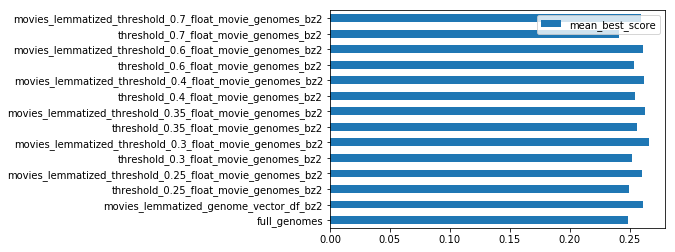

In [52]:
from time import time

test_users = all_user_ids[:93]

start = time()
get_results_for_all_dfs(test_users)
finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.5072825029906858
best_user 127031
mean_best_score 0.2440000540663451 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.5573847699226004
best_user 127031
mean_best_score 0.2534066695864855 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.5097425273756977
best_user 127031
mean_best_score 0.2496973943679936 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.5565018553352624
best_user 127031
mean_best_score 0.2531130864633179 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.5144938823027461
best_user 127031
mean_best_score 0.2517696715646981 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.56064958069694
best_user 127031
mean_best_score 0.25267275443059767 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.5153279892580547
best_user 127031
mean_best_score 0.25271220952

<Figure size 432x288 with 0 Axes>

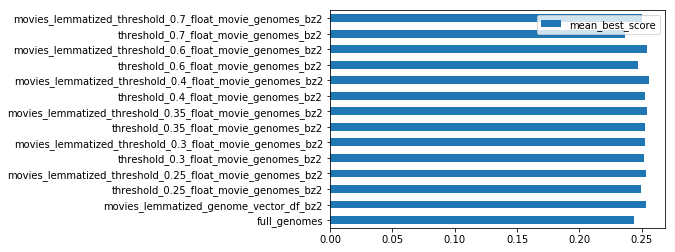

In [53]:
test_users = all_user_ids[94:187]

start = time()
get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.525843998806037
best_user 145675
mean_best_score 0.2042005165618434 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.6626007819440154
best_user 145675
mean_best_score 0.22788143468574362 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.5594991236871433
best_user 145675
mean_best_score 0.2142912657987556 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.6911288311023156
best_user 145675
mean_best_score 0.2292330496568399 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.5677109834428206
best_user 145675
mean_best_score 0.2169632613294082 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.6992615565232253
best_user 145675
mean_best_score 0.22841840375439945 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.5701062702685484
best_user 145675
mean_best_score 0.218802267

<Figure size 432x288 with 0 Axes>

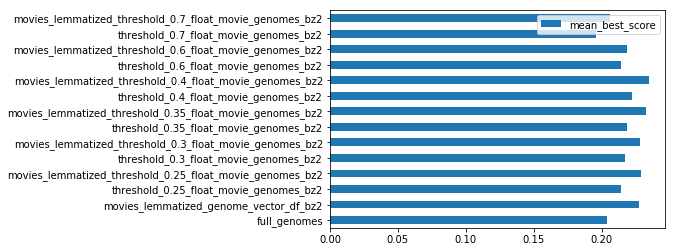

In [54]:
test_users = all_user_ids[188:280]
start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.3851632784584435
best_user 160486
mean_best_score 0.23145981057927717 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.45964761612704796
best_user 200683
mean_best_score 0.23534560201453802 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.38434587531899816
best_user 160486
mean_best_score 0.23249407518519224 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.43299796832010995
best_user 200683
mean_best_score 0.23881576421116515 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.3893120218789715
best_user 160486
mean_best_score 0.23168797143894412 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.43528470948245085
best_user 206554
mean_best_score 0.24348121856429436 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.3957225052558949
best_user 160486
mean_best_score 0.

<Figure size 432x288 with 0 Axes>

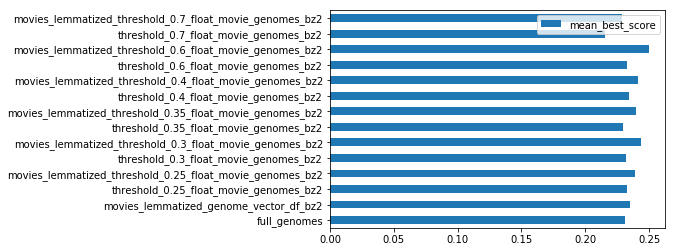

In [55]:
test_users = all_user_ids[281:]
start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)

processing for:  full_genomes
highest_score 0.3851632784584435
best_user 160486
mean_best_score 0.23145981057927717 

processing for:  movies_lemmatized_genome_vector_df_bz2
highest_score 0.45964761612704796
best_user 200683
mean_best_score 0.23534560201453802 

processing for:  threshold_0.25_float_movie_genomes_bz2
highest_score 0.38434587531899816
best_user 160486
mean_best_score 0.23249407518519224 

processing for:  movies_lemmatized_threshold_0.25_float_movie_genomes_bz2
highest_score 0.43299796832010995
best_user 200683
mean_best_score 0.23881576421116515 

processing for:  threshold_0.3_float_movie_genomes_bz2
highest_score 0.3893120218789715
best_user 160486
mean_best_score 0.23168797143894412 

processing for:  movies_lemmatized_threshold_0.3_float_movie_genomes_bz2
highest_score 0.43528470948245085
best_user 206554
mean_best_score 0.24348121856429436 

processing for:  threshold_0.35_float_movie_genomes_bz2
highest_score 0.3957225052558949
best_user 160486
mean_best_score 0.

<Figure size 432x288 with 0 Axes>

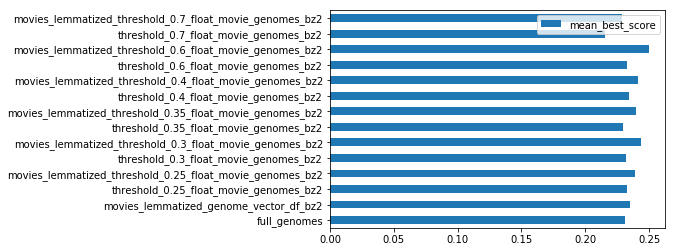

In [57]:
# file_name = 'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2'
# genomes_df = pd.read_pickle(data_dir + '/output/' + file_name, compression='bz2')
# genomes_df

# known_best_users = [1110, 1050, 391, 71, 81, 41, 31, 1]
known_best_users = [114756, 127031, 145675, 160486, 200683, 191484, 192643, 206554, 200754]

start = time()

get_results_for_all_dfs(test_users)

finish = time() - start
print('Total time: %f seconds' % finish)